# Project 3: Real world data
- Explore the data.
- Train at least three different regression models and cross-validate them with MSE and R2-score.
- Try out pre-processing techniques.
- Choose two types of feature selection and implement at least one method for each.
Experimentally evaluate your feature selections.
- For the best performing combination of model and pre-processing steps, implement and plot the so-called learning curve
on your own.

## Function definitions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display
import math
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# generic function to extract named properties from the data set items
# fs is a list of tuples, first a name, then a function mapping an item to a property
def property_table(fs, ds):
    keys = list(ds.keys()) # row names
    prop_names = fs.keys() # column names
    funcs = fs.values() # property functions
    items = list(map(lambda t: t[1], ds.items())) # data items
    mapped = zip(*list(map(lambda f: map(f, items), funcs))) # each prop for each item
    df = pd.DataFrame(mapped, index=keys, columns=prop_names) # use pandas.DataFrame to print a table
    display(df)

def plane(X, a, b):
    return list(map(lambda v: [v[a], v[b]], X))

def gauss_sum(n):
    return int((n**2+n)/2)

def plot_plane(X, ax, a, b):
    #min = np.minimum(a,b)
    #b = np.maximum(a,b)
    #a=min
    p=plane(X, a, b)
    ax.scatter(*zip(*p), s=1.0,  c=y)
    ax.set_title(f"Plane ({a}, {b})")

def plot_hyperspace(X):
    dim_count = len(X[0])
    #print(f"dim_count = {dim_count-1}")

    plane_count = gauss_sum(dim_count-1)
    #print(f"{plane_count}")

    grid_width = 7
    grid_height = math.ceil(plane_count/grid_width)
    #print(f"grid_height = {grid_height}")

    plt.close('all')
    width=dim_count
    for a in range(0, width):
        fig, axs = plt.subplots(1, width)
        fig.set_figwidth(width*2)
        fig.set_figheight(2)
        for b in range(0, width):
            #k = b + a*width
            #print(f"k={k} p=({a}, {b})")
            plot_plane(X, axs[b], a, b)
        plt.tight_layout()

CROSS_VAL_FOLDS=100
# train and score model using cross validation
def score_model(name, model, data, y, scoring):
    #print(f'Scoring {name} model')
    return cross_val_score(model, data, y, cv=CROSS_VAL_FOLDS, scoring=scoring)
    #print(f'{name}_score = {avg_score}')

# score a dictionary of models
def score_models(models, data, y, scoring):
    #print(f'Scoring: {scoring}')
    return { name: score_model(name, model, data, y, scoring) for name, model in models.items() }

## Data exploration

,Count,Shape,Min,Max,Mean,Std
X,1460,"(1460, 20)","[1300, 1, 1, 1872, 0, 334, 0, 334, 0, 0, 0, 2,...","[215245, 10, 9, 2010, 6110, 4692, 2065, 5642, ...","[10517.0, 6.0, 6.0, 1971.0, 1057.0, 1163.0, 34...","[9978.0, 1.0, 1.0, 30.0, 439.0, 386.0, 436.0, ..."
y,1460,"(1460, 1)",[34900],[755000],[180921.0],[79415.0]


,Min,Max,Mean,Std
LotArea,1300,215245,10517.0,9978.0
OverallQual,1,10,6.0,1.0
OverallCond,1,9,6.0,1.0
YearBuilt,1872,2010,1971.0,30.0
TotalBsmtSF,0,6110,1057.0,439.0
1stFlrSF,334,4692,1163.0,386.0
2ndFlrSF,0,2065,347.0,436.0
GrLivArea,334,5642,1515.0,525.0
FullBath,0,3,2.0,1.0
HalfBath,0,2,0.0,1.0


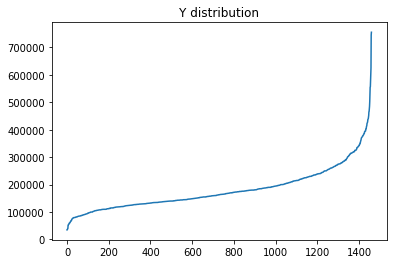

In [10]:
# TODO: load dataset 1
data_set = np.load('dataset.npz')
X = data_set['X']
y = data_set['y']
features = data_set['features']
property_table({
    'Count': lambda item: len(item),
    'Shape': lambda item: item.shape,
    'Min': lambda item: np.round(np.amin(item, axis=0)),
    'Max': lambda item: np.round(np.amax(item, axis=0)),
    'Mean': lambda item: np.round(np.mean(item, axis=0)),
    'Std': lambda item: np.round(np.std(item, axis=0)),
}, {
    "X": X,
    "y": y
})
plt.title("Y distribution")
plt.plot(sorted(y))
feature_dict = { name: np.choose(i, X.T) for (i, name) in enumerate(features)}
property_table({
    'Min': lambda item: np.round(np.amin(item, axis=0)),
    'Max': lambda item: np.round(np.amax(item, axis=0)),
    'Mean': lambda item: np.round(np.mean(item, axis=0)),
    'Std': lambda item: np.round(np.std(item, axis=0)),
}, feature_dict)

#plot_hyperspace(X)

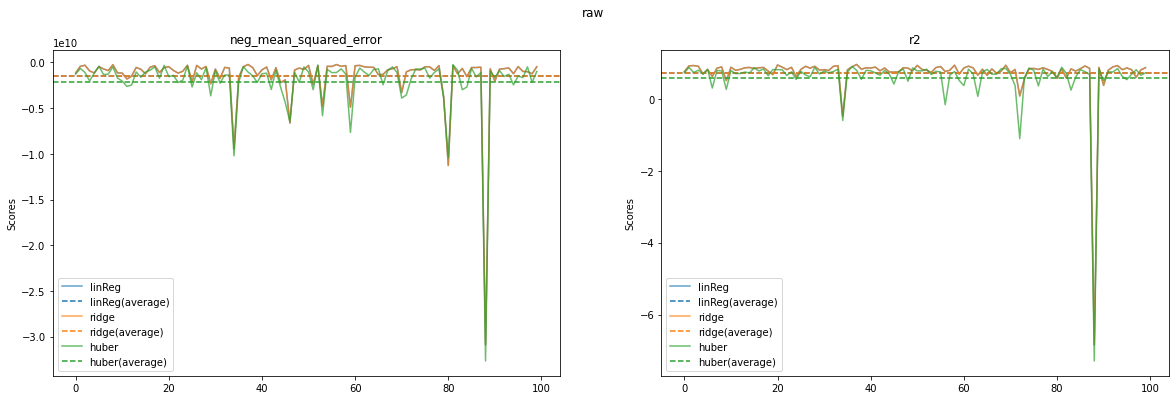

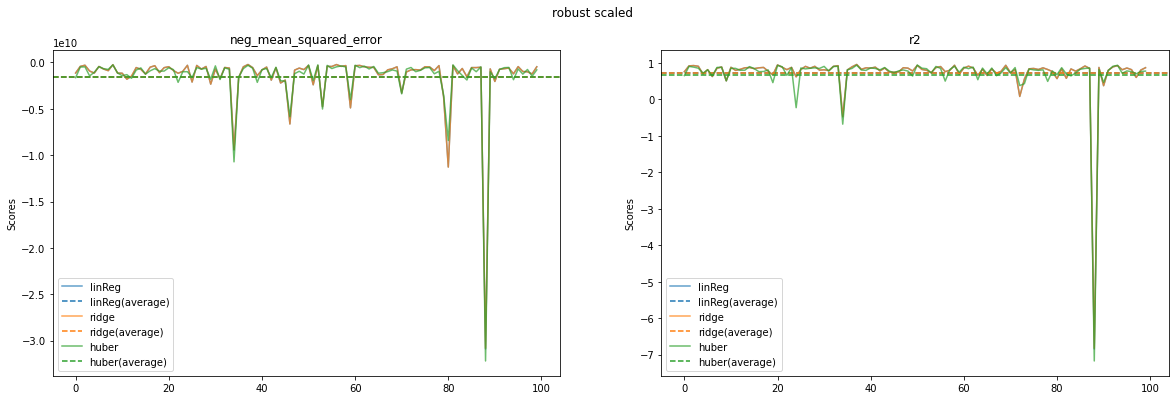

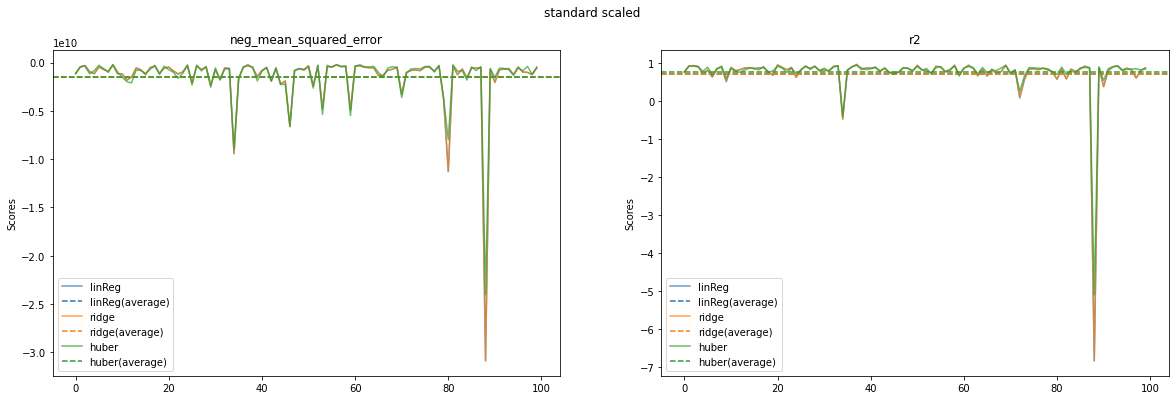

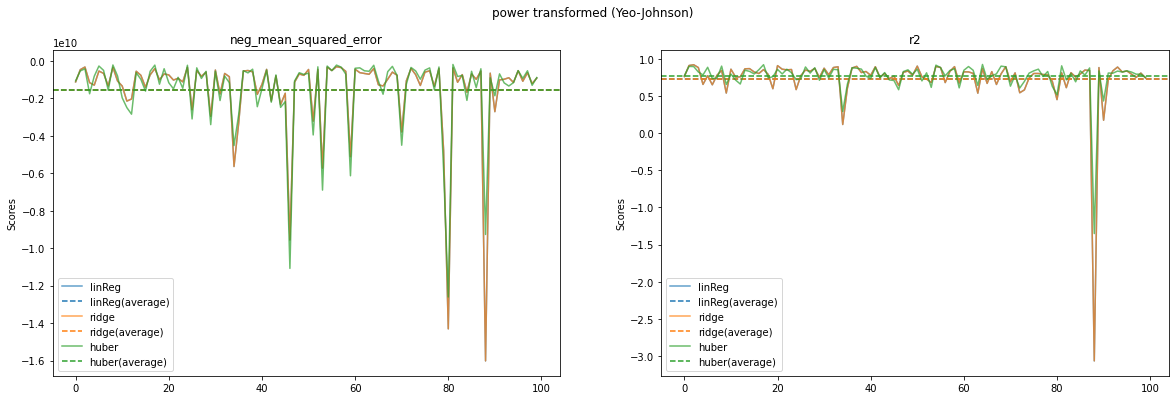

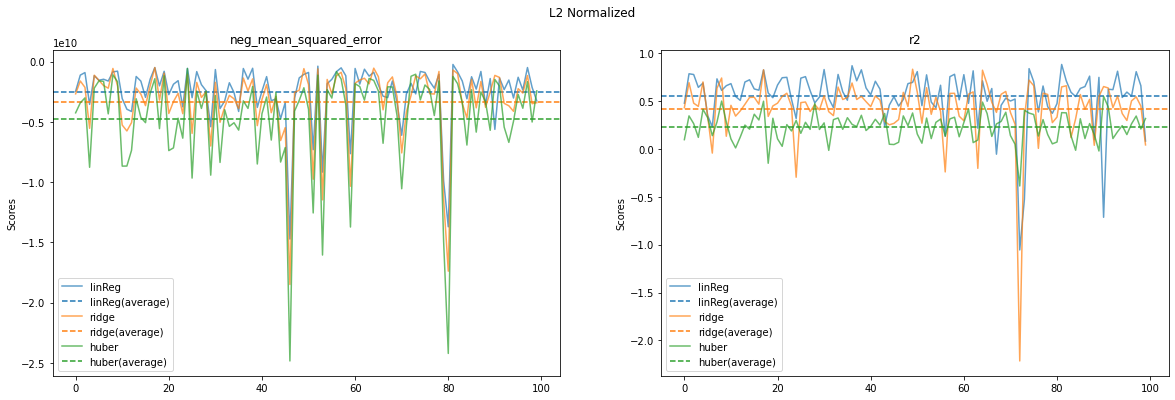

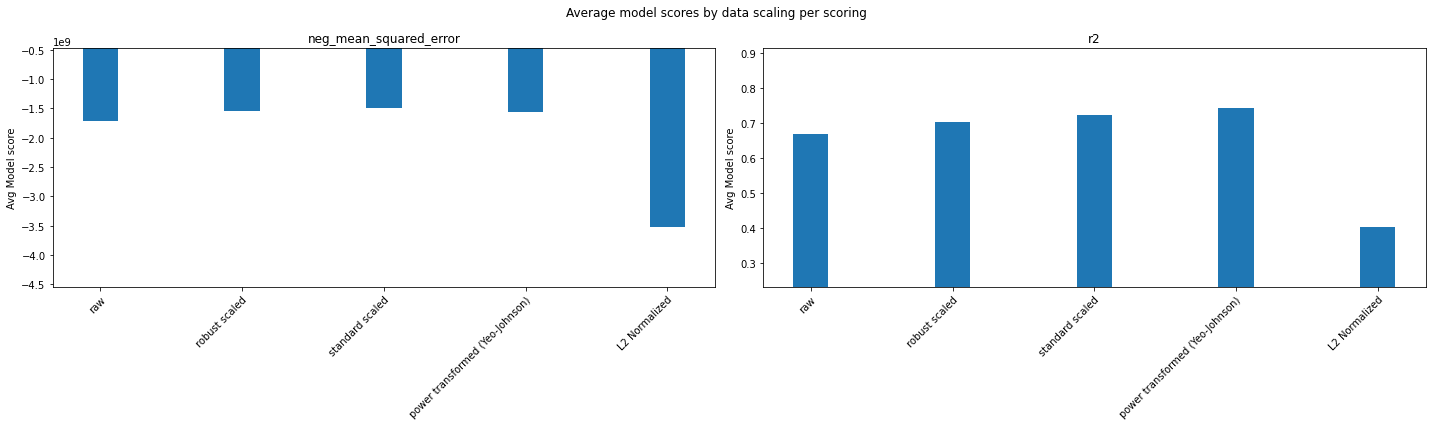

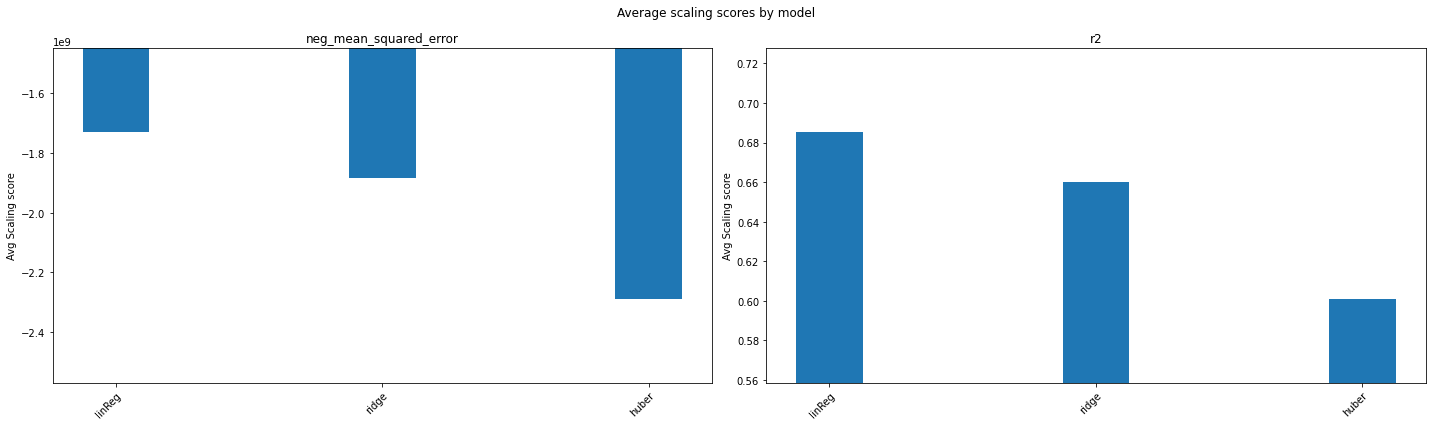

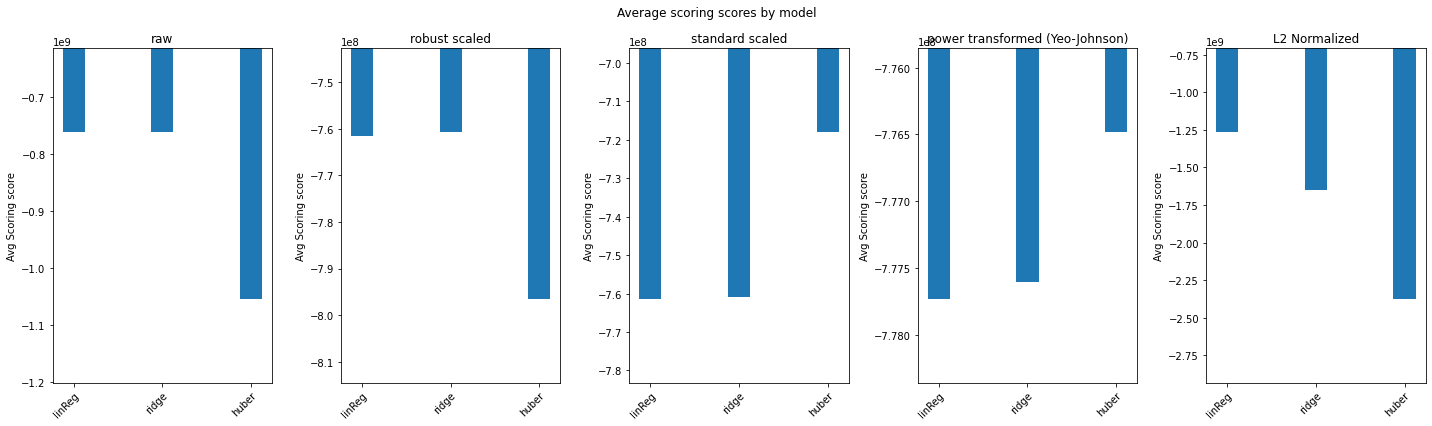

In [19]:
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer
# test multiple models on an input
def score_models_on_data(regs, name, data, y, scorings):
    #print(f'Scoring models on {name} data')
    #print(f'{name} = {X}')
    return { scoring: score_models(regs, data, y.ravel(), scoring) for scoring in scorings }

# test multiple models on multiple data scalings using multiple scorings
def score_all_models_on_all_data_using_all_scorings(regs, data, y, scorings):
    # data_scores is a 4D dictionary "tensor" containing
    # scoring_scores for each data scaling
    # scoring_scores are 3D dictionaries containing
    # model_scores for each scoring
    # model_scores are 2D dictionaries containing
    # scores for each model
    # scores are 1D arrays of scores with length CROSS_VAL_FOLDS
    data_scores = { name: score_models_on_data(regs, name, x, y, scorings) for name, x in data.items() }

    for (i, (name, scoring_scores)) in enumerate(data_scores.items()):
        plot_model_scores_for_data(name, scoring_scores)

    plot_avg_model_scores_by_data_scaling(data_scores)
    plot_avg_data_scaling_scores_by_model(data_scores)

# transpose first two levels of dictionary
def sub_keys(d):
    return { key for sub in d.values() for key in sub.keys() }
# transpose first two levels of dictionary
def transpose_dict(d):
    keys = sub_keys(d)
    return {
        key: { k:d[k][key] for k in d if key in d[k] } for key in keys
    }

# plot each scalings scores averaged across all models
def plot_avg_model_scores_by_data_scaling(data_scores):
    # average scores across models
    avg_data_scores = {
        scaling: {
            scoring: np.mean(np.array(list(model_scores.values())), axis=(0,1))
            for scoring, model_scores in scoring_scores.items()
        } for scaling, scoring_scores in data_scores.items()
    }
    # transpose so that scoring dictionary is top level
    avg_data_scores_transposed = transpose_dict(avg_data_scores)
    #print(avg_data_scores_transposed)
    plot_bar_charts_for_dicts(
        "Average model scores by data scaling per scoring",
        "Avg Model score",
        avg_data_scores_transposed
    )

# plot each models scores averaged across all data scalings
def plot_avg_data_scaling_scores_by_model(data_scores):
    transposed = transpose_dict(data_scores)
    transposed_again = {
        scoring: transpose_dict(data_scores) for scoring, data_scores in transposed.items()
    }
    avg_model_scores_transposed = {
        scoring: {
            model: np.mean(np.array(list(data_scores.values())), axis=(0,1))
            for model, data_scores in model_scores.items()
        } for scoring, model_scores in transposed_again.items()
    }
    plot_bar_charts_for_dicts(
        "Average scaling scores by model",\
        "Avg Scaling score",
        avg_model_scores_transposed
    )

# plot one titled, labelled bar chart for each nested dictonary in dicts
def plot_bar_charts_for_dicts(title, ylabel, dicts):
    plt.figure(figsize=(20,6))
    plt.suptitle(title)
    n = len(dicts)
    for (i, (name, data)) in enumerate(dicts.items()):
        plt.subplot(1,n,i+1)
        plot_bar_chart(ylabel, name, data)

def plot_bar_chart(ylabel, name, data, width=0.25):
    # barchart from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
    values = data.values()
    ind = np.arange(len(values))
    low = min(values)
    high = max(values)
    plt.gca().set_ylim([low - 0.5000*(high-low), high + 0.5000*(high-low)])
    plt.gca().bar(ind, values, width)
    plt.gca().set_title(name)
    plt.gca().set_ylabel(ylabel)
    plt.gca().set_xticks(ind)
    plt.gca().set_xticklabels(data.keys(), rotation=45, rotation_mode="anchor", ha="right")
    plt.gcf().tight_layout()
    return

def plot_model_scores_for_data(data_name, scoring_scores):
    plt.figure(figsize=(20,6))
    plt.gcf().suptitle(data_name)
    n = len(scoring_scores)
    for (i, (scoring, model_scores)) in enumerate(scoring_scores.items()):
        plt.subplot(1,n,i+1)
        plt.title(scoring)
        plot_model_scores(model_scores)

def plot_model_scores(scores):
    plt.ylabel("Scores")
    for name, scores in scores.items():
        plot_model_score(name, scores)
    plt.legend()

def plot_model_score(name, scores):
    #print(f"Plotting scores for model {name}")
    #print(f"Scores {scores.shape}")
    avg_score = np.mean(scores)
    c = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(scores, color=c, label=name, alpha=0.7)
    plt.axhline(avg_score, color=c, linestyle="--", label=f"{name}(average)")

def scale(data, scaler):
    return scaler.fit_transform(data)

# TODO: train a Logistic Regression, ridge regression and Huber loss regression using cross validation
scorings = [
    "neg_mean_squared_error",
    "r2"
]
regs = {
    "linReg": LinearRegression(),
    "ridge": Ridge(),
    "huber": HuberRegressor(),
}

# Some scalers from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
data = {
    "raw": X,
    "robust scaled": scale(X, RobustScaler()),
    "standard scaled": scale(X, StandardScaler()),
    "power transformed (Yeo-Johnson)": scale(X, PowerTransformer(method='yeo-johnson')),
    #"quantile transformed (uniform)": scale(X, QuantileTransformer(output_distribution='uniform')),
    #"quantile transformed (gaussian)": scale(X, QuantileTransformer(output_distribution='normal')),
    "L2 Normalized": scale(X, Normalizer()),
}

# causes error with unscaled dataset
#score("logReg", logReg, X, y)

# huber regressor throws warnings even on scaled data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    score_all_models_on_all_data_using_all_scorings(regs, data, y, scorings)


{'neg_mean_squared_error': {'raw': -1243648355.6694143, 'robust scaled': -1383403164.2080665, 'standard scaled': -1248795839.7418497, 'power transformed (Yeo-Johnson)': -1294899423.69477, 'L2 Normalized': -4066896866.4298415}, 'r2': {'raw': 0.7557251634993137, 'robust scaled': 0.7545263074425225, 'standard scaled': 0.759589106396351, 'power transformed (Yeo-Johnson)': 0.7809873205455853, 'L2 Normalized': 0.2768980357525559}}


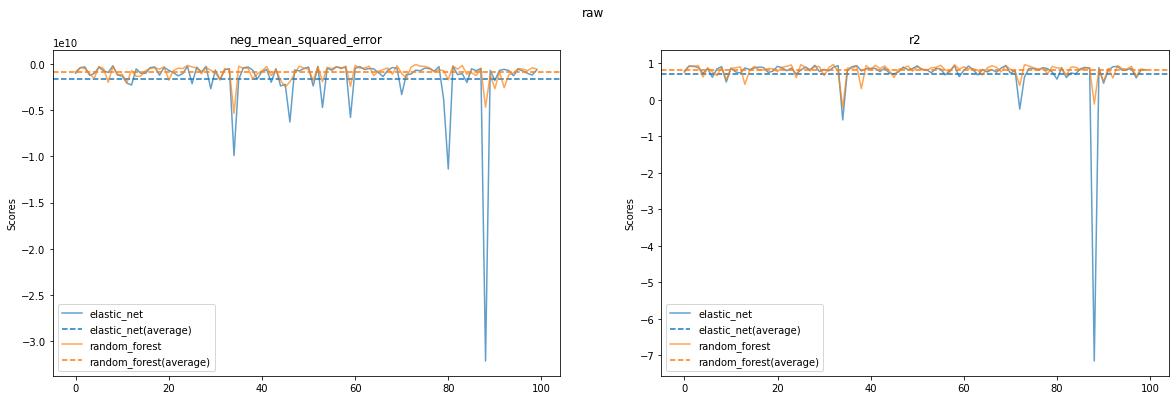

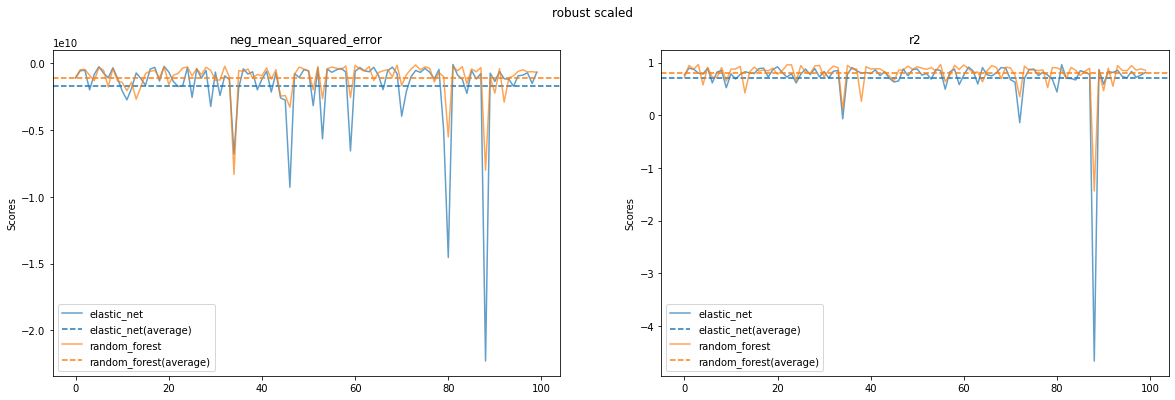

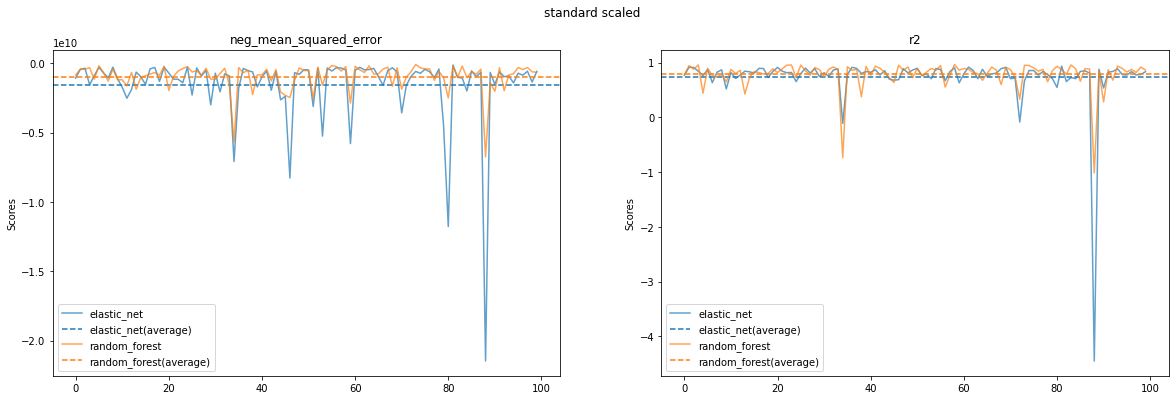

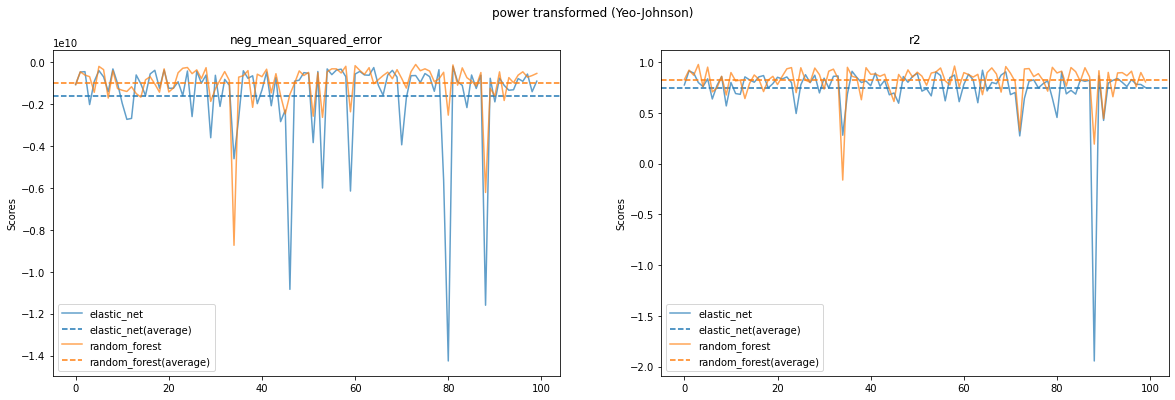

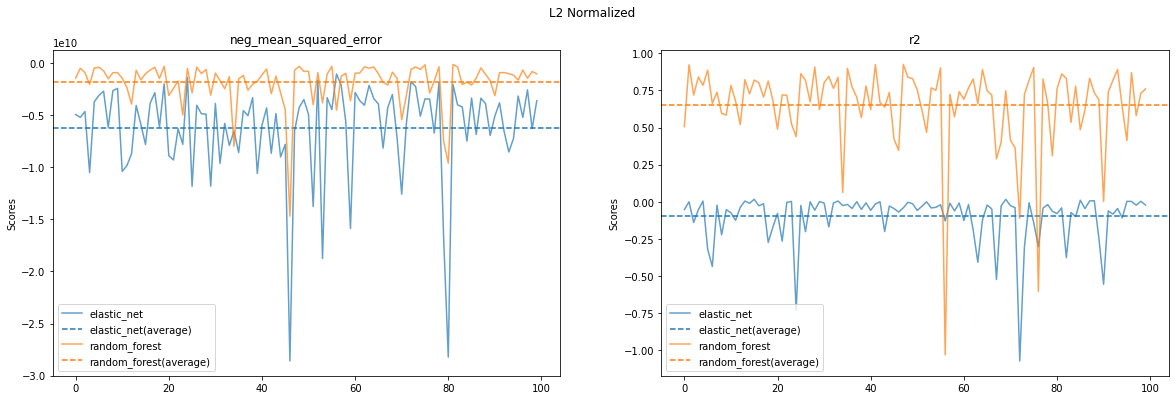

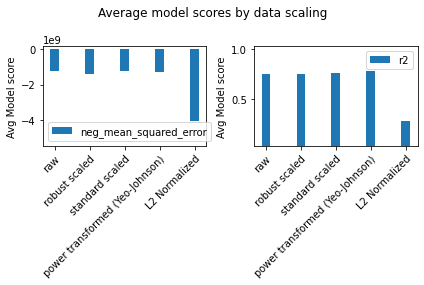

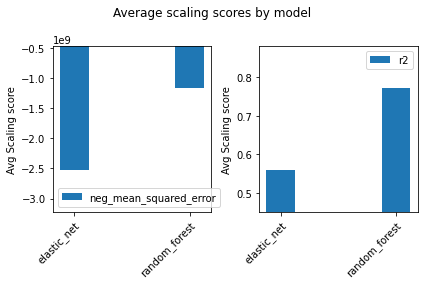

In [14]:
# Todo: evaluate different techniques of feature selection

regs = {
    #"elastic_net": ElasticNet(),
    "random_forest": RandomForestRegressor(n_estimators=10),
    "random_forest(mean absolute error)": RandomForestRegressor(n_estimators=10, criterion="mae"),
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    score_all_models_on_all_data_using_all_scorings(regs, data, y, scorings)

**TODO:** Analyze your results.

Using a standard scaler results in a dataset with near-zero mean and a variance of 1 for all features. The mean is not exactly zero due to limited floating-point precision, which means that the calculated mean of the original dataset may not exactly match its true mean. The error between the actual mean and the floating point representation is what causes the mean of the transformed dataset to not be exactly zero. But it is so close to zero that it is practically zero.

The scaling removed the varying variances between the features which allows the kNN classifier to make better predictions. Also logistic regression now converges, because the error for the decision boundary doesn't exceed a certain threshold anymore.

The gaussianNB classifier does not perform differently for different scalings, as this plot illustrates:

In [ ]:
score("raw", gaussianNB, X, y)
score("standardized", gaussianNB, standard_scaled, y)
score("min_max", gaussianNB, min_max_scaled, y)
plt.legend()